In [1]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

In [2]:
%matplotlib inline
import pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from Bio import SeqIO

# Settings for proper export of svg files for AI and paper style
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['font.family'] = 'Carlito'
plt.rcParams['figure.dpi'] = 100
# Some tweaks for font clarity in figures

sns.set_context('paper', rc={'xtick.labelsize':11,'ytick.labelsize':11,"font.size":12,"axes.titlesize":13,"axes.labelsize":12,'pdf.fonttype':42,'ps.fonttype':42,'font.family':'Carlito'})


In [3]:
candidate_file = '../../SNPdb/data/20170307_KRAS.xlsx'
df_candidates = pd.read_excel(candidate_file)
candidate_ids = list(df_candidates['oldID'])
fasta_w200 = '../../SNPdb/data/snps_100padding.fasta'

In [4]:
!wc -l $fasta_w200

452034 ../../SNPdb/data/snps_100padding.fasta


In [5]:
df_candidates

,selecetion_criteria,orig-xls-index,Gene name,Accession Number,Gene CDS length,HGNC ID,Mutation CDS,GRCh,Mutation genome position,Mutation strand,...,LOH,FATHMM prediction,FATHMM score,Mutation somatic status,Gene Name Count,Gene Name Count / CDS Length,Codon,Total Codons,Codon Location in CDS,UCSC Alt Events
0,By Codon Location (less than 18) and Rank Sum ...,34003,KRAS,ENST00000311936,567,6407,c.30A>C,38,12:25245355-25245355,-,...,u,PATHOGENIC,0.93624,Confirmed somatic variant,25,0.044092,10,189,0.05291,NaN


In [6]:
recs = SeqIO.parse(fasta_w200, "fasta")
n = 0
candidate_recs = dict()

for record in recs:
    splits = record.id.split('|')
    rec_oldid =  ('_'.join(splits[:-2] + splits[-1:])).replace(' ','')

    if rec_oldid in candidate_ids:
        n += 1
        assert(rec_oldid not in candidate_recs)
        candidate_recs[rec_oldid] = record
    

In [7]:
import sys
sys.path.append( '../../../mmfold/local_dotplot/' )
import local_dotplot_lib as ldp

def makeSafeFilename(inputFilename):   
    try:
        safechars = string.letters + string.digits + " -_."
        return filter(lambda c: c in safechars, inputFilename)
    except:
        return ""  


from Bio.SeqRecord import SeqRecord
def get_CD_record(full_rec, utr5_len, utr3_len):
    if utr3_len == 0:
        CD_seq = full_rec.seq[utr5_len:]
    else:
        CD_seq = full_rec.seq[utr5_len: -utr3_len]
    CD_rec = SeqRecord(CD_seq, id=full_rec.id+'-CDS', name=full_rec.name, description='utr5-0 utr3-0')
    return CD_rec


def write_dp_from_matrix(matrix, out_dp, template_dp):
    import itertools
    from math import sqrt
    import re
    ureg = re.compile(r'^(\d+)\s+(\d+)\s+(\d+\.\d+)\s+[ul]box\s*')
    with open(template_dp) as template, open(out_dp, 'w') as out_handle:
        # Write first part before probs
        for line in template:
            if "ubox" in line or "lbox" in line:
                um = ureg.match(line)
                if um:
                    break
            out_handle.write(line)
        cx = matrix.tocoo()
        #Write alternative given probs
        for i,j,p in zip(cx.row, cx.col, cx.data):# used to have itertoolz.izip in Python2
            if abs(p) >= 1e-5:
                out_handle.write("{} {} {:1.9f} ubox\n".format(i+1,j+1,sqrt(abs(p))))
        #Write remianing footer after probs
        for line in template:
            if "ubox" in line or "lbox" in line:
                um = ureg.match(line)
                if um:
                    continue
            out_handle.write(line)

def write_diff_dp(dp_wild, dp_mut, out_dp):
    '''Reads two dotplot matrices and write the absoloute difference of basepair probs into out_dp'''
    #     print "write_diff_dp: ", dp_wild, dp_mut, out_dp
    mut_matrix, mfe_dic = ldp.parse_dp_ps_sparse(dp_wild, sparse=True)
    wild_matrix, mfe_dic = ldp.parse_dp_ps_sparse(dp_mut, sparse=True)
    assert mut_matrix.shape == wild_matrix.shape
    diff_mat = (mut_matrix - wild_matrix)
    write_dp_from_matrix(diff_mat, out_dp=out_dp, template_dp=dp_wild)


from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from subprocess import Popen, PIPE
from os.path import isfile



def call_vienna_plfold(sequence, seq_name, do_localfold=False):
    '''Runs Vienna RNAfold with partition function for all sequences inside input fasta file '''

    from subprocess import Popen, PIPE
    dp_file_name = "{}_dp.ps".format(seq_name)
    unp_file_name = "{}_lunp".format(seq_name)
    if isfile(dp_file_name): # Caution Race condition may occur 
        os.remove(dp_file_name)
    if isfile(unp_file_name): # Caution Race condition may occur 
        os.remove(unp_file_name)
    
    RNAFOLD = 'RNAfold -p2 '
    RNAPLFOLD = 'RNAplfold -W 200 -L 150 -u 1 '  # -u 1 for unpaired probablitiy 
    RNAPLFOLD1200 = 'RNAplfold -W 1200 -L 1150 -u 1 '
    print (sequence)
    assert len(sequence.split()) == 1
    cmd = ('echo ">%s\\n%s\\n" | '%(seq_name, sequence))  
    if do_localfold:
        cmd += RNAPLFOLD 
    else:
        cmd += RNAPLFOLD1200
    print(cmd)
    p = Popen(cmd, stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    print (out)
    print (err)
    has_error = False
    if err:
        if b"warn" in err.lower():
            print ("Warning in calling call_RNAfold:\n {} {}\n".format(out, err))
        else:
            raise RuntimeError("Error in calling call_RNAfold: {} {}\n".format(out, err))
    if not isfile(dp_file_name):
        raise RuntimeError("Error: Expected dp file: {} is not created!".format(dp_file_name))
    if not isfile(unp_file_name):
        raise RuntimeError("Error: Expected lunp file: {} is not created!".format(unp_file_name))
    
    return dp_file_name, unp_file_name

# call_RNAfold_pf("ACCGGCUUAAAGG", "seq1")
def run_dot2circ(dp_file, name):
    file_name_string = "".join(x for x in dp_file if x not in ['|','<', '>'])
    print ("dp_file:", dp_file, file_name_string)
    
    # Invok example: python dot2circ.py --prefix "test2" --local-fold 1 --dp-file dp.ps
    CIRCOS_PATH ='/home/milad/1software/circos/circos-0.69-2/bin/'
    cmd = 'CIRCOS={}; export PATH=$CIRCOS:$PATH;'.format(CIRCOS_PATH)  
    cmd += 'cd ./dot2circ/; python dot2circ.py --prefix \'{}\' --dp-file ../\'{}\' --title \'{}\' '.format(name, file_name_string, name)
    print (cmd)
    p = Popen(cmd, stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    print (out)
    print (err)
    has_error = False
    if err:
        raise RuntimeError("Error in calling dot2circ.py: {} {}\n".format(out, err))

    
def create_circos_annotation(CDS_len, utr5_len, utr3_len, snp_locs, snp_names):
    '''
    Genes formatted Example:
    seq 193 759 CDS fill_color=green,r0=1.01r,r1=1.01r+20p
    seq 0 192  5UTR fill_color=yellow,r0=1.01r,r1=1.01r+20p
    seq 760 5765  3UTR fill_color=yellow,r0=1.01r,r1=1.01r+20p
    seq 227 228 SN-86 fill_color=vdred,r0=1.03r,r1=1.03r+20p
    '''
    print ("snp_locs:", snp_locs)
    start = 0
    formatted_str = ""
    if utr5_len is not None:
        formatted_str += 'seq {} {} 5UTR fill_color=yellow,r0=1.01r,r1=1.01r+20p\n'.format(start, start+utr5_len)
        start += utr5_len + 1 # Tocheck: maybe plus one not needed?
    if CDS_len is not None:
        formatted_str += 'seq {} {} CDS fill_color=green,r0=1.01r,r1=1.01r+20p\n'.format(start, start+CDS_len)
        start += CDS_len + 1 # Tocheck: maybe plus one not needed?
    if utr3_len is not None:
        formatted_str += 'seq {} {} 3UTR fill_color=yellow,r0=1.01r,r1=1.01r+20p\n'.format(start, start+utr3_len)
        start += utr3_len + 1 # Tocheck: maybe plus one not needed?
    if snp_locs is not None:
        for i in range(len(snp_locs)):
            formatted_str += 'seq {} {} c.-{} fill_color=vdred,r0=1.03r,r1=1.03r+20p\n'.format(snp_locs[i], snp_locs[i]+1, snp_names[i])
    print (formatted_str)
    genes_file =  './dot2circ/data/genes.formatted.txt'
    with open (genes_file, 'w') as genes_out:
        genes_out.write(formatted_str)
        

import re
def plot_circos_seq_SNP(rec_wild, SNP_tag, local_fold=False, plotted_seq_lenght=None):
    from Bio import SeqIO
    if local_fold:
        suffix = "-W200"
    else:
        suffix = "-W1200"
    
    ID = '_'.join(rec_wild.id.split('|')[:2])+'_'+SNP_tag#"".join(x for x in rec_wild.id if x not in ['|','<', '>'])
    utr5_l, utr3_l = 0, 0 
    #     print "rec_wild: " , rec_wild
    wild_seq = rec_wild.seq
    # print wild_seq

    matches =  re.match('(\D)(\d+)(\D)', SNP_tag)
    if not matches:
        raise RuntimeError("No matches founs for tag:".format(SNP_tag)) 
    wild_char, loc, mut_char = matches.group(1), int(matches.group(2)), matches.group(3)
    assert(wild_seq[loc-1].upper() == wild_char.upper())
    mut_seq = wild_seq[:loc-1] + mut_char + wild_seq[loc:]
    
    #print mut_seq
    rec_mut = SeqRecord(mut_seq, id=ID+'-MUTANT')

    dp_full, unp_full = call_vienna_plfold(rec_wild.seq, ID, local_fold)
    create_circos_annotation(len(rec_wild), utr5_l, utr3_l, None, [""])
    run_dot2circ(dp_full, ID+suffix)
        
    dp_mut, unp_mut = call_vienna_plfold(rec_mut.seq, rec_mut.id, local_fold)
    create_circos_annotation(len(rec_mut), utr5_l, utr3_l, [int(SNP_tag[1:-1])], [SNP_tag])
    run_dot2circ(dp_mut, rec_mut.id+suffix)
    dp_diff = dp_mut.replace('.ps', '_diff.ps')
    write_diff_dp(dp_full, dp_mut, dp_diff)
    run_dot2circ(dp_diff, rec_mut.id+suffix+'-diff')
    
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
# Test case
# my_rec = SeqRecord(Seq("ACGGCGUCCGG"),
#                    id="id1")

# plot_circos_seq_SNP(my_rec, 'C2G', local_fold=True)

In [8]:
import re
def plot_circos_seq_annotate(rec, annotate_indices, annotate_names, local_fold=False, plotted_seq_lenght=None,utr5_l=0, utr3_l = 0,color='r' ):
    from Bio import SeqIO
    if local_fold:
        suffix = "-W200"
    else:
        suffix = "-W1200"
    
    seq = rec.seq

    if len(annotate_indices) != len(annotate_names):
        raise RuntimeError("Mismatch indic/names: {}, {} }".format(len(annotate_indices), len(annotate_names))) 
    
    ID = rec.id
    dp_full, unp_full = call_vienna_plfold(rec.seq, ID, local_fold)
    create_circos_annotation(len(rec), utr5_l, utr3_l, annotate_indices, annotate_names)

    run_dot2circ(dp_full, ID+suffix)
        
    #dp_diff = dp_mut.replace('.ps', '_diff.ps')
    #write_diff_dp(dp_full, dp_mut, dp_diff)
    #run_dot2circ(dp_diff, rec_mut.id+suffix+'-diff')
    
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
# Test case
# my_rec = SeqRecord(Seq("ACGGCGUCCGGACGGCGUCCGGACGGCGUCCGGACGGCGUCCGGACGGCGUCCGGACGGCGUCCGGACGGCGUCCGGACGGCGUCCGGACGGCGUCCGGACGGCGUCCGG"),
#                    id="id1")

# plot_circos_seq_annotate(my_rec, [22,28,30,40],['A','B','C','D'], local_fold=True)

In [9]:
import re
def plot_circos_seq_pair(rec_wild, rec_mut, local_fold=False, plotted_seq_lenght=None):
    from Bio import SeqIO
    if local_fold:
        suffix = "-W200"
    else:
        suffix = "-W1200"
    
    wild_seq = rec_wild.seq
    utr5_l, utr3_l = 0, 0 
        # print wild_seq

    mut_seq = rec_mut.seq
    
    print (len(wild_seq), '==', len(mut_seq))
    dp_full, unp_full = call_vienna_plfold(rec_wild.seq, rec_wild.id, local_fold)
    create_circos_annotation(len(rec_wild), 71, utr3_l, 
                             #None,None,None, 
                             [100],
                                              
                             #None,None,None,0,
                             snp_names=["WT"]
    )
    run_dot2circ(dp_full, rec_wild.id+suffix)
        
    dp_mut, unp_mut = call_vienna_plfold(rec_mut.seq, rec_mut.id, local_fold)
    create_circos_annotation(len(rec_mut), 71, utr3_l, 
                             #None,None,None,
                             [100], 
                           #None,None,None, None, 
                             snp_names=["A30C"])
    run_dot2circ(dp_mut, rec_mut.id+suffix)
    dp_diff = dp_mut.replace('.ps', '_diff.ps')
    write_diff_dp(dp_full, dp_mut, dp_diff)
    run_dot2circ(dp_diff, rec_mut.id+suffix+'-diff')

    

# With context
# KRAS_WT_C100='TATTAACCTTATGTGTGACATGTTCTAATATAGTCACATTTTCATTATTTTTATTATAAGGCCTGCTGAAAATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCAAGAGTGCCTTGACGATACAGCTAATTCAGAATCATTTTGTGGACGAATATGATCCAACAATAGAGGTAAATCTTGTTTTAATAT'
# KRAS_A30C_C100='TATTAACCTTATGTGTGACATGTTCTAATATAGTCACATTTTCATTATTTTTATTATAAGGCCTGCTGAAAATGACTGAATATAAACTTGTGGTAGTTGGCGCTGGTGGCGTAGGCAAGAGTGCCTTGACGATACAGCTAATTCAGAATCATTTTGTGGACGAATATGATCCAACAATAGAGGTAAATCTTGTTTTAATAT'
# rec_kras_wt = SeqRecord(Seq(KRAS_WT_C100),
#                    id="KRAS-WT-C100")
# rec_kras_a30c = SeqRecord(Seq(KRAS_A30C_C100),
#                    id="KRAS-A30C-C100")
# plot_circos_seq_pair(rec_kras_wt, rec_kras_a30c, local_fold=False, )

In [10]:
def plot_circos_seq_pair(rec_wild, rec_mut, local_fold=False, plotted_seq_lenght=None):
    from Bio import SeqIO
    if local_fold:
        suffix = "-W200"
    else:
        suffix = "-W1200"
    
    wild_seq = rec_wild.seq
    utr5_l, utr3_l = 0, 0 
        # print wild_seq

    mut_seq = rec_mut.seq
    
    print (len(wild_seq), '==', len(mut_seq))
    dp_full, unp_full = call_vienna_plfold(rec_wild.seq, rec_wild.id, local_fold)
    create_circos_annotation(len(rec_wild), 0, utr3_l, 
                             #None,None,None, 
                             [29],
                                              
                             #None,None,None,0,
                             snp_names=["WT"]
    )
    run_dot2circ(dp_full, rec_wild.id+suffix)
        
    dp_mut, unp_mut = call_vienna_plfold(rec_mut.seq, rec_mut.id, local_fold)
    create_circos_annotation(len(rec_mut), 0, utr3_l, 
                             #None,None,None,
                             [29], 
                           #None,None,None, None, 
                             snp_names=["A30C"])
    run_dot2circ(dp_mut, rec_mut.id+suffix)
    dp_diff = dp_mut.replace('.ps', '_diff.ps')
    write_diff_dp(dp_full, dp_mut, dp_diff)
    run_dot2circ(dp_diff, rec_mut.id+suffix+'-diff')


# In silico transcribed
KRAS_WT= 'ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCAAGAGTGCCTTGACGATACAGCTAATTCAG'
KRAS_A30C = 'ATGACTGAATATAAACTTGTGGTAGTTGGCGCTGGTGGCGTAGGCAAGAGTGCCTTGACGATACAGCTAATTCAG'

rec_kras_wt = SeqRecord(Seq(KRAS_WT),
                   id="KRAS-WT")
rec_kras_a30c = SeqRecord(Seq(KRAS_A30C),
                   id="KRAS-A30C")

# plot_circos_seq_annotate(rec_kras_wt, [30],['30A'], local_fold=True)
# plot_circos_seq_annotate(rec_kras_a30c, [30],['30C'], local_fold=True)
plot_circos_seq_pair(rec_kras_wt, rec_kras_a30c, local_fold=False, )

75 == 75
ATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCAAGAGTGCCTTGACGATACAGCTAATTCAG
echo ">KRAS-WT\nATGACTGAATATAAACTTGTGGTAGTTGGAGCTGGTGGCGTAGGCAAGAGTGCCTTGACGATACAGCTAATTCAG\n" | RNAplfold -W 1200 -L 1150 -u 1 
b'>KRAS-WT\n'
b'WARNING: window size 1200 larger than sequence length 75\n'
Warning in calling call_RNAfold:
 b'>KRAS-WT\n' b'WARNING: window size 1200 larger than sequence length 75\n'

snp_locs: [29]
seq 0 0 5UTR fill_color=yellow,r0=1.01r,r1=1.01r+20p
seq 1 76 CDS fill_color=green,r0=1.01r,r1=1.01r+20p
seq 77 77 3UTR fill_color=yellow,r0=1.01r,r1=1.01r+20p
seq 29 30 c.-WT fill_color=vdred,r0=1.03r,r1=1.03r+20p

dp_file: KRAS-WT_dp.ps KRAS-WT_dp.ps
CIRCOS=/home/milad/1software/circos/circos-0.69-2/bin/; export PATH=$CIRCOS:$PATH;cd ./dot2circ/; python dot2circ.py --prefix 'KRAS-WT-W1200' --dp-file ../'KRAS-WT_dp.ps' --title 'KRAS-WT-W1200' 
b'calling: " circos -param image/file**="KRAS-WT-W1200.png" -param ideogram/show_label=yes "\nb\'debuggroup summary 0.15s welcome to ci

/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


b'calling: " circos -param image/file**="KRAS-A30C-W1200-diff.png" -param ideogram/show_label=yes "\nb\'debuggroup summary 0.15s welcome to circos v0.69 6 Dec 2015 on Perl 5.026002\\ndebuggroup summary 0.15s current working directory /media/milad/ubuntu14/home/milad/workspace/MutaRNA/public-github/src/dot2circ\\ndebuggroup summary 0.15s command /home/milad/1software/circos/circos-0.69-2/bin//circos -param image/file**=KRAS-A30C-W1200-diff.png -param ideogram/show_label=yes\\ndebuggroup summary 0.15s guessing configuration file\\ndebuggroup summary 0.15s found conf file /media/milad/ubuntu14/home/milad/workspace/MutaRNA/public-github/src/dot2circ/circos.conf\\ndebuggroup summary 0.30s debug will appear for these features: output,summary\\ndebuggroup summary 0.30s bitmap output image ./KRAS-A30C-W1200-diff.png\\ndebuggroup summary 0.30s SVG output image ./KRAS-A30C-W1200-diff.svg\\ndebuggroup summary 0.30s parsing karyotype and organizing ideograms\\ndebuggroup summary 0.30s karyotype ha

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_up_dict(up_dic, plot_lims=None, title='XX', fig=None, diff=False,tidy=False):
    if plot_lims is None:
        x, y = up_dic.keys(), up_dic.values()
    else:
        x, y = up_dic.keys()[plot_lims[0]:plot_lims[1]+1], up_dic.values()[plot_lims[0]:plot_lims[1]+1]
    if fig is None:
        fig = plt.figure(figsize=(9, 3))

    ax = fig.add_subplot(111) 
    ax.plot(x, y, label=title)
    if not tidy:
        ax.legend(loc='upper left')#, bbox_to_anchor=(0.0, 1.1))


    import numpy as np
    minor_ticks = np.arange(min(x), max(x), 1)                                               
    major_ticks = np.arange(min(x)-min(x)%5, max(x), 5)                                               

    ax.set_xticks(minor_ticks, minor=True)                                           
    ax.set_xticks(major_ticks) 
    ax.set_xlabel('Position')
    if diff:
        ax.set_yticks([-1, 1], minor=True)                                           
        ax.set_ylim([-1.05,1.05])
        ax.set_ylabel('Accessibility(WT) - Accessibility(MUT)')
    else:
        ax.set_yticks([0,1], minor=True)                                           
        ax.set_ylim([-0.05,1.05])
        ax.set_ylabel('Accessibility')
#     ax.grid(which='both')                                                            

    # or if you want differnet settings for the grids:                               
    ax.grid(which='minor', alpha=0.5)
    ax.axhline(0)
#     ax.axhline(0, linestyle='--', color='k', alpha=0.5) # horizontal lines
#     ax.axhline(1, linestyle='--', color='k', alpha=0.5) # horizontal lines
    
    ax.set_xlim([min(x)-1, max(x)+1])
    if not tidy:
        ax.set_title(title)
    

def get_unpaired_probs(unp_file):
    # Read Vienna RNAplfold unpaired prob file (-u 1) into dict
    with open(unp_file) as unp_in:
        line1 = unp_in.readline()
        if "#unpaired probabilities" not in line1:
            raise IOError('Unexpected header for lunp file: {}'.format(line1))
        line2 = unp_in.readline()
        if "#i$\tl=1" not in line2:
            raise IOError('Unexpected second header for lunp file: {}'.format(line2))
        up_dic = dict()
        for line in unp_in:
            splits = line.split()
            assert len(splits) >= 2
            pos = int(splits[0])
            up_prob = float(splits[1])
            assert pos >=1
            assert up_prob >= 0 and up_prob <= 1
            assert pos not in up_dic
            up_dic[pos] = up_prob
            
    
    return up_dic

# myfig = plt.figure(figsize=(20, 5))
# myupfile = '../../bin/chr10_95069379_G201T-MUTANT_lunp'
# plot_up_dict(get_unpaired_probs(myupfile), None, title=os.path.basename(myupfile).replace('_lunp',''), fig=myfig,tidy=True)

In [12]:
import seaborn as sns
import numpy as np

def heatmap_up_dict(up_dic, plot_lims=None, title='XX', ax=None,diff=False,
                    ticklabel=True,legend=True):
    if plot_lims is None:
        x, y = list(up_dic.keys()), list(up_dic.values())
    else:
        x, y = list(up_dic.keys())[plot_lims[0]:plot_lims[1]+1], list(up_dic.values())[plot_lims[0]:plot_lims[1]+1]
    
    
    if ax is None:
        ax = fig.add_subplot(121)
    ax.yaxis.set_label_position("right")

    # Now adding the colorbar
#     pos1 = ax.get_position() # get the original position 
#     pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0]
    if legend:
        cax = fig.add_axes([1.0, 0.5, 0.1, .1])
    else:
        cax = None

#     ax.plot(x, y, label=title)
#     sns.pointplot(x,y,ax=ax)
    sns.heatmap(np.reshape(np.array(y),(len(y),1)), cmap=sns.cubehelix_palette(as_cmap=True), ax=ax, 
                cbar=legend,cbar_ax=cax,vmin=0.0, vmax=1.0,
                yticklabels=x, 
               )
#     cbar = ax.collections[0].colorbar
#     cbar.set_ticks([0., .2, .4, .6, .8, 1.0])
    
#     cbar.set_ticklabels(['low', '20%', '75%', '100%'])
    if legend:
        ax.legend(loc='upper left')#, bbox_to_anchor=(0.0, 1.1))

    minor_ticks = np.arange(min(x), max(x), 1)                                               
    major_ticks = np.arange(min(x)-min(x)%10, max(x), 10)                                               
    yticks = x
    keptticks = yticks[::10]
    yticks = ['' for y in yticks]
    yticks[::10] = keptticks
#     ax.set_yticks(minor_ticks,                   minor=True)
    from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FormatStrFormatter,FuncFormatter,IndexLocator,StrMethodFormatter
    minorLocator = IndexLocator(1,offset=0.5)
    majorLocator = IndexLocator(10,offset=0.5)
    def incer(x, pos):
        'The two args are the value and tick position'
        return '%d' % (x+1)

    majorFormatter = FuncFormatter(incer)
#     majorFormatter = StrMethodFormatter('{x}',use_offset=False                                       )

#     ax.set_yticklabels(yticks, rotation=0,)

    ax.yaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_major_locator(majorLocator)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    if ticklabel:
        ax.yaxis.set_major_formatter(majorFormatter)
#         ax.set_yticklabels(yticks, rotation=0,)

#         ax.tick_params(which='minor', length=6)

        ax.yaxis.set_label_position("right")
    else:
        ax.set_yticklabels([])
#     ax.set_yticks(major_ticks) 
#     ax.set_ylabel('Position')
#     ax.set_yticks([-1, 1], minor=False, )                                           

    if diff:
        ax.set_xticks([-1, 1], minor=True)                                           
        ax.set_xlim([-1.05,1.05])
        ax.set_xlabel('P_unpaired(wild) - P_unpaired(mut)')
    else:
        ax.set_xticks([], minor=False,)                                           
#         ax.set_xlim([-0.05,1.05])
#         ax.set_xlabel('Accessibility')
#     ax.grid(which='both')                                                            

    # or if you want differnet settings for the grids:                               
#     ax.grid(which='minor', alpha=0.5) 
#     ax.axhline(0, linestyle='--', color='k', alpha=0.5) # horizontal lines
#     ax.axhline(1, linestyle='--', color='k', alpha=0.5) # horizontal lines
    
#     ax.set_ylim([min(x)-1, max(x)+1])
    ax.set_title(title,rotation=90,va='bottom')

    

# myupfile = '../../bin/KRAS-invitro-CellLineMUT-A30C_lunp' # './chr10_95069379_G201T-MUTANT_lunp'

# myfig, ax = plt.subplots(1,figsize=(.5, 11))

# heatmap_up_dict(get_unpaired_probs(myupfile), None, title=os.path.basename(myupfile).replace('_lunp',''), 
#                 ax=ax, ticklabel=True,legend=False)
 

/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


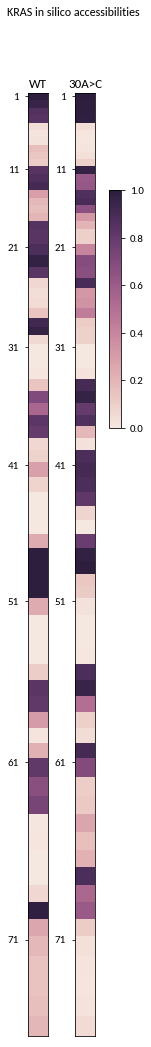

In [13]:
def get_incremental_range(n,init_step=1, increase_rate=1.1):
    cur_val = 0
    arr = [0]
    step = init_step
    rates = (np.array([18,19.5,20.5,30,30.5,39,43,48,52]))/10
    for i in range(n):
        alpha = (i%10)/10.0
        arr.append(arr[-1]+ alpha*rates[i//10]+(1-alpha)*rates[i//10+1])
#         cur_val == i*increase_rate #step
#         step *= (1+increase_rate)
    return arr

def plot_shape_like(vals,ax):
    y = get_incremental_range(len(vals))
    x = range(0,2)
    C = np.vstack([np.array(vals),np.arange(0,len(vals))])
    X,Y = np.meshgrid(x,y)
    pcmesh = ax.pcolormesh(X,Y,np.array(C.T),cmap=sns.cubehelix_palette(light=0.92,as_cmap=True),vmin=0,vmax=1)
    ax.set_yticks([yy+0.7 for i,yy in enumerate(y) if i%10==0])
    ax.set_yticklabels([i+1 for i,yy in enumerate(y) if i%10==0])
    ax.invert_yaxis()
    ax.tick_params(axis='x',bottom='off',which='both')
    ax.get_xaxis().set_visible(False)
    return pcmesh 
# ax.set_labe

fig = plt.figure(figsize=(2.2, 15))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_axes([0.3, .5, 0.5, 0.4]) 
fig.tight_layout(w_pad=0.1)
ax3.set_visible(False)
myupfile = '../../bin/KRAS-invitro-GenomeWT-A30C_lunp'
plot_shape_like(list(get_unpaired_probs(myupfile).values()),ax1)
myupfile = '../../bin/KRAS-invitro-GenomeMUT-A30C_lunp'
cmap = plot_shape_like(list(get_unpaired_probs(myupfile).values()),ax2)


cbar = fig.colorbar(cmap,ax=ax3)
cbar.set_clim(0,1)

# cbar.ax.set_xticklabels(np.arange(0,1,0.2))  # horizontal colorba

ax1.set_title('WT')
ax2.set_title('30A>C')
fig.suptitle('KRAS in silico accessibilities')
fig.subplots_adjust(top=0.9)
fig.savefig('./KRAS-invitro-GenomeWT-heatmap.svg')

fig.savefig('./KRAS-invitro-GenomeWT-heatmap.pdf')

../../bin/KRAS-invitro-GenomeWT-A30C_lunp ../../bin/KRAS-invitro-GenomeMUT-A30C_lunp


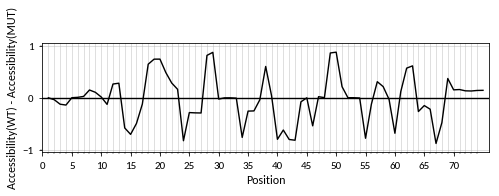

/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


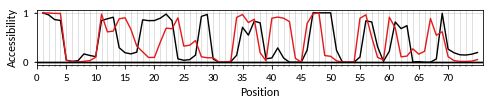

In [14]:
from cycler import cycler
import seaborn as sns

plt.rc('axes', prop_cycle=(cycler('color', ['k',(0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]
#                                   sns.color_palette()
#                                   [sns.color_palette("Paired")[1], sns.color_palette("Paired")[-1]]
                                  #                                   sns.color_palette("RdBu_r", 2)
#                                   ['k', 'b', 'r', 'g']
                                 ) 
#                            +                            cycler('linestyle', ['-', '--', ':', '-.']) 
                          ))

def plot_unpaired_probs(up_file_pairs, plot_heatmap=False,rang=None):
    for up_file_wild, up_file_mut in up_file_pairs:
        print (up_file_wild, up_file_mut)
        d_wild = get_unpaired_probs(up_file_wild)
        d_mut = get_unpaired_probs(up_file_mut)
        dict_diff = {f:(d_wild[f] - d_mut[f])  for f in d_wild}
        if plot_heatmap:
            title_key = 'heatmap'
            fig, ax = plt.subplots(1,figsize=(0.5, 11))
            heatmap_up_dict(dict_diff, rang, title=os.path.basename(up_file_wild).replace('-WT-','-').replace('_lunp','-DIFF'), ax=ax, diff=True)
        else:
            title_key = 'ECG'

            fig = plt.figure(figsize=(8, 2))
            plot_up_dict(dict_diff, rang, title=os.path.basename(up_file_wild).replace('-WT-','-').replace('_lunp','-DIFF')
                         , fig=fig, diff=True,tidy=True)
        fig.savefig(up_file_wild+'-diff-{}.png'.format(title_key), bbox_inches='tight', pad_inches=0.2
                   )
        fig.savefig(up_file_wild+'-diff-{}.svg'.format(title_key), bbox_inches='tight', pad_inches=0.2
                   )
        plt.show()
        
        if plot_heatmap:
            fig = plt.figure(figsize=(2.5, 11),tight_layout={'w_pad':2})

        else:
            fig = plt.figure(figsize=(8, 1))
        labeldic = {0:True, 1:False}
        for iup, up_file in enumerate([up_file_wild, up_file_mut]):
            if plot_heatmap:
                ax = fig.add_subplot(131+iup*2) # Skip one ax in dirty way for cbar
                heatmap_up_dict(get_unpaired_probs(up_file), rang, title=os.path.basename(up_file).replace('-MUT-','-').replace('-WT-','-').replace('_lunp',''), 
                                ax=ax,ticklabel=labeldic[iup])            
            else:
                plot_up_dict(get_unpaired_probs(up_file), rang, title=os.path.basename(up_file).replace('-MUT-','-').replace('-WT-','-').replace('_lunp',''), 
                             fig=fig,tidy=True,
#                              ax=ax, ticklabel=labeldic[iup]
                            )            
            
#         fig.tight_layout(pad=0.1)

#         fig.savefig(up_file_wild.replace('WT','WTMUT')+'-{}.png'.format(title_key), bbox_inches='tight', #pad_inches=0.5,
#                     dpi=300)
        fig.savefig(up_file_wild.replace('WT','WTMUT')+'-{}.svg'.format(title_key), bbox_inches='tight', #pad_inches=0.5,
                    )
        
# wil_mut_selection = [(m.replace('MUT-','WT-'), m) for m in ['./KRAS-invitro-GenomeMUT-A30C_lunpCellLineMUT-A30C_lunp']]
wil_mut_selection = [('../../bin/KRAS-invitro-GenomeWT-A30C_lunp','../../bin/KRAS-invitro-GenomeMUT-A30C_lunp')]
# plot_unpaired_probs(wil_mut_selection, plot_heatmap=True)

plot_unpaired_probs(wil_mut_selection, plot_heatmap=False)

/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/milad/miniconda3/envs/mutarnaPy3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


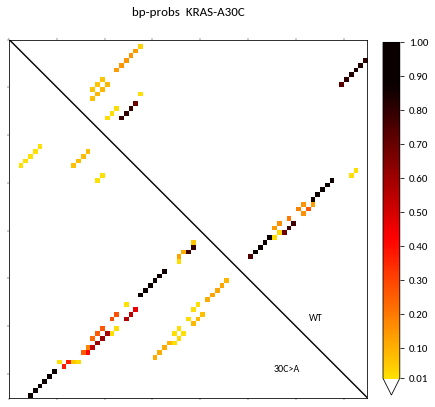

In [15]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys, os
import matplotlib as mpl
mpl.rc("savefig", dpi=500)
from matplotlib import pyplot as plt
sys.path.append( '../../../mmfold/local_dotplot/' )
import local_dotplot_lib as ldp
import glob
chunk = 0
prot = 'KRAS'

wildmat = ldp.parse_dp_ps('../../bin/KRAS-invitro-GenomeWT-A30C_dp.ps')
mutmat = ldp.parse_dp_ps('../../bin/KRAS-invitro-GenomeMUT-A30C_dp.ps')

# ldp.plot_heat_maps(None, wildmat, filename='', what='basepairs',
#                    inverse=True, interactive=False, gene_loc=None)
# ldp.plot_heat_maps(None, mutmat, filename='', what='basepairs',
#                    inverse=True, interactive=False, gene_loc=None)
fig = ldp.plot_heat_maps(None, wildmat+mutmat.transpose(), filename='', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None,title_suffix='  KRAS-A30C')
fig.text(x=0.72,y=0.3,s='WT')
fig.text(x=0.65,y=0.2,s='30C>A')
fig.savefig('KRAS-invitro-A30C-paired.png',dpi=600)
fig.savefig('KRAS-invitro-A30C-paired.svg',dpi=600)